## Датасет: возраст по фотографии
https://chalearnlap.cvc.uab.cat/dataset/26/description/#

Из папок train, val, test взять только файлы с лицами: в названии имеют .jpg_face.jpg
разложить их по папкам train_new, test_new, valid_new.

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import pandas as pd
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
import shutil
from torchvision import models, transforms
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import albumentations as A
from PIL import Image
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Preprocessing

Т.к. файл с разметкой один на train, test и valid имеет названия файлов без .jpg_face.jpg создаём файлы с разметкой отдельно с кооректными именами картинок.

In [3]:
labels = pd.read_csv('../cv/datasets/faces/labels.csv',sep=';')
labels = labels[['file_name','real_age']]

In [4]:
tr_lst = list(labels['file_name'])
tr_lst = [x.split('.') for x in tr_lst]
tr_lst = [x[0]+'.jpg_face.jpg' for x in tr_lst]
labels['file_name_new'] = tr_lst

In [5]:
directory = '../cv/datasets/faces/other files/test_new/'
file_list=[] 
for filename in os.listdir(directory):
    file_list.append(filename)
labels_test = pd.DataFrame(file_list)
labels_test.columns = ['file_name_new']
labels_test=labels_test.merge(labels, on='file_name_new', how='inner')

directory = '../cv/datasets/faces/other files/train_new/'
file_list=[] 
for filename in os.listdir(directory):
    file_list.append(filename)
labels_train = pd.DataFrame(file_list)
labels_train.columns = ['file_name_new']
labels_train=labels_train.merge(labels, on='file_name_new', how='inner')

directory = '../cv/datasets/faces/other files/valid_new/'
file_list=[] 
for filename in os.listdir(directory):
    file_list.append(filename)
labels_valid = pd.DataFrame(file_list)
labels_valid.columns = ['file_name_new']
labels_valid=labels_valid.merge(labels, on='file_name_new', how='inner')

In [6]:
labels_train.drop('file_name',axis=1,inplace=True)
labels_test.drop('file_name',axis=1,inplace=True)
labels_valid.drop('file_name',axis=1,inplace=True)

In [7]:
len(labels_train)+len(labels_test)+len(labels_valid) # должно быть 7591 файл

7591

In [8]:
train_img_dir = '../cv/datasets/faces/other files/train_new/'
val_img_dir = '../cv/datasets/faces/other files/valid_new/'
test_img_dir = '../cv/datasets/faces/other files/test_new/'

In [9]:
labels_train.reset_index(inplace=True, drop=True)
labels_test.reset_index(inplace=True, drop=True)
labels_valid.reset_index(inplace=True, drop=True)

### Dataset and dataloader

In [10]:
data_transforms = {
'train': A.Compose([
    A.Resize(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomShadow(p=0.6),
    A.Rotate(limit=40, p=0.5),
    A.ToGray(p=0.3)
    ]),
'val': A.Compose([
    A.Resize(width=224, height=224),
    ]),
'test': A.Compose([
    A.Resize(width=224, height=224)
    ])
}

In [11]:
class ImageDataset(Dataset):
    def __init__(self, labels, img_dir, transform=None, target_transform=None):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
            image = torch.from_numpy(image)
            image = torch.transpose(torch.transpose(image,1,2),0,1)
            image = image/255
            
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
train_dataset = ImageDataset(labels_train,train_img_dir, transform=data_transforms['train'])
val_dataset = ImageDataset(labels_valid,val_img_dir, transform=data_transforms['val'])
test_dataset = ImageDataset(labels_test,test_img_dir, transform=data_transforms['test'])
image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [14]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
dataset_sizes

{'train': 4113, 'val': 1500, 'test': 1978}

### Test image preview

In [15]:
test_loader_show = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
train_features, train_labels = next(iter(test_loader_show))

age: tensor(19)
torch.Size([16, 3, 224, 224])


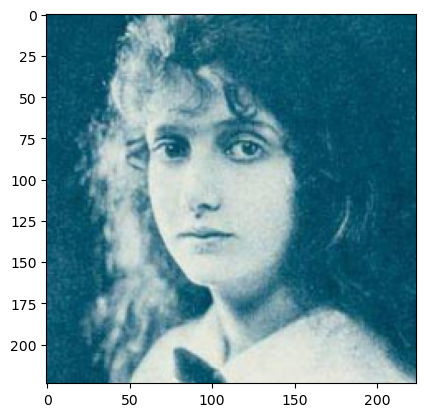


age: tensor(76)
torch.Size([16, 3, 224, 224])


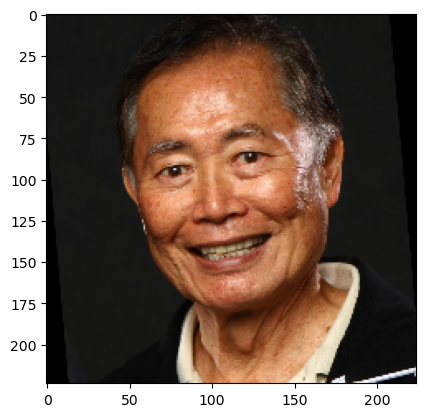


age: tensor(40)
torch.Size([16, 3, 224, 224])


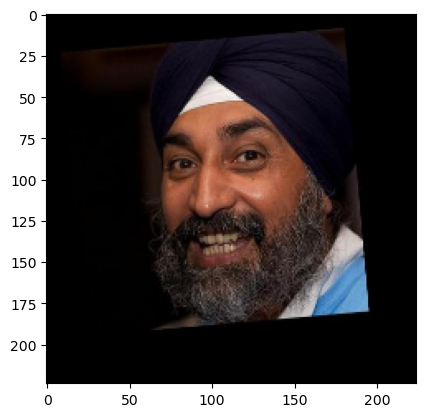


age: tensor(21)
torch.Size([16, 3, 224, 224])


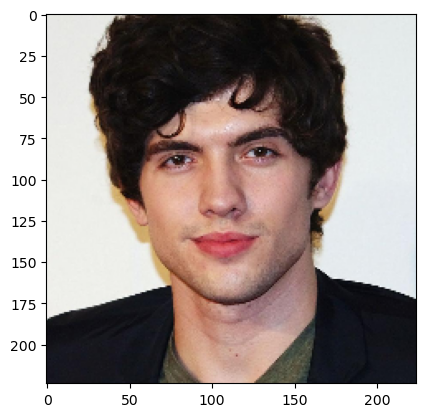


age: tensor(34)
torch.Size([16, 3, 224, 224])


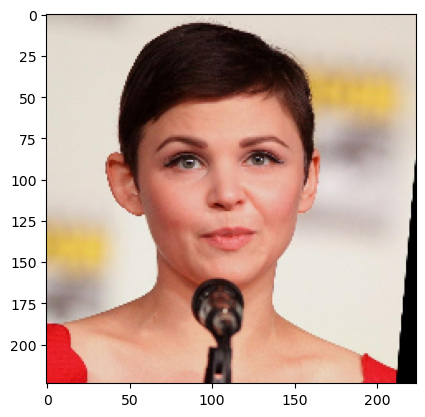


age: tensor(36)
torch.Size([16, 3, 224, 224])


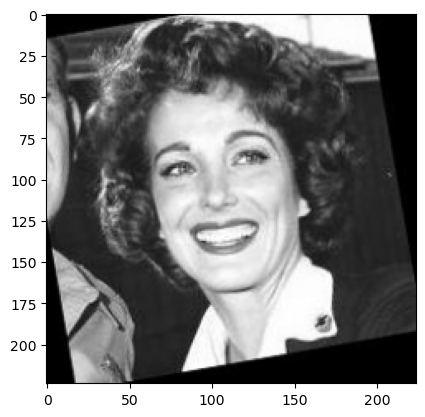


age: tensor(36)
torch.Size([16, 3, 224, 224])


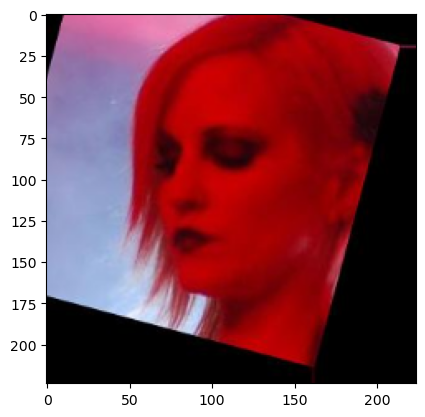


age: tensor(52)
torch.Size([16, 3, 224, 224])


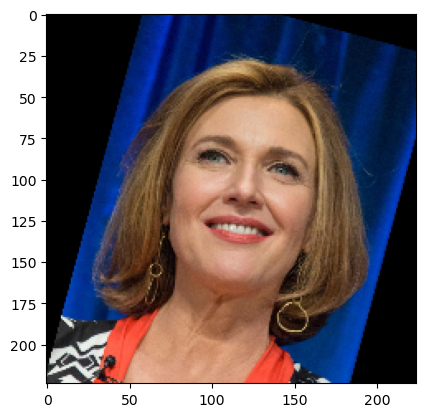


age: tensor(16)
torch.Size([16, 3, 224, 224])


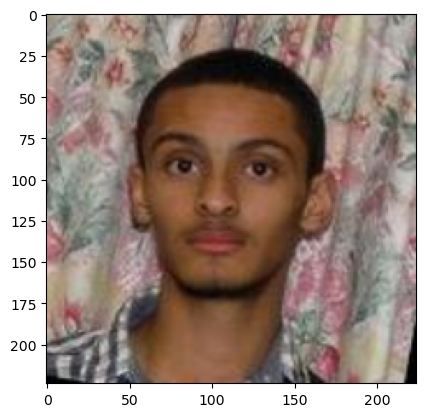


age: tensor(59)
torch.Size([16, 3, 224, 224])


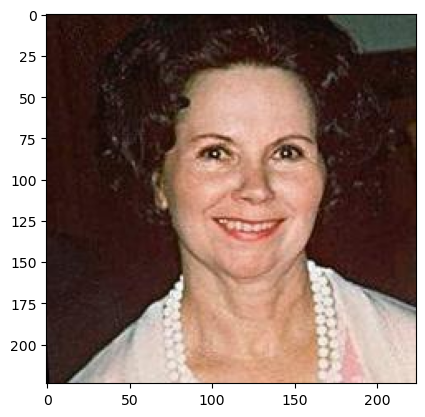


age: tensor(53)
torch.Size([16, 3, 224, 224])


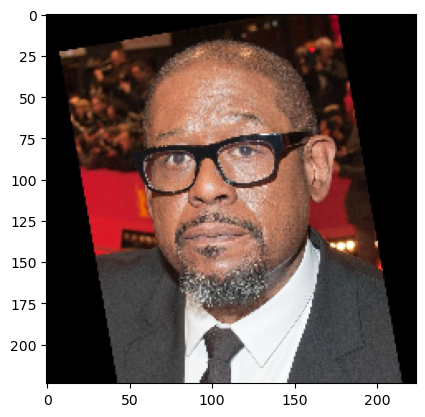


age: tensor(32)
torch.Size([16, 3, 224, 224])


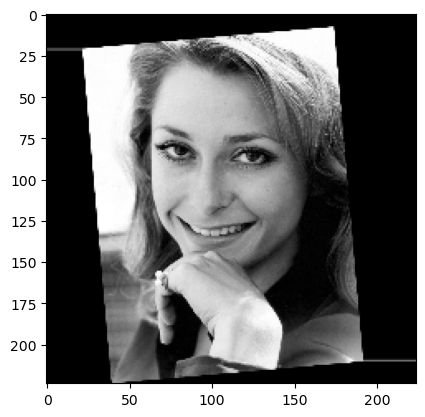


age: tensor(27)
torch.Size([16, 3, 224, 224])


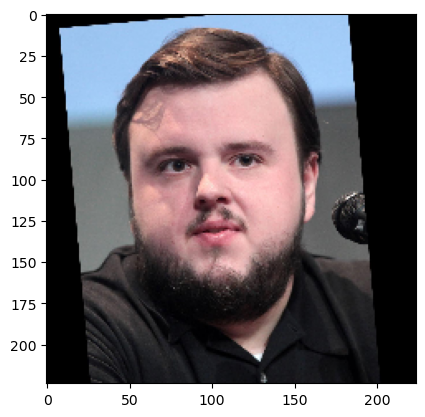


age: tensor(22)
torch.Size([16, 3, 224, 224])


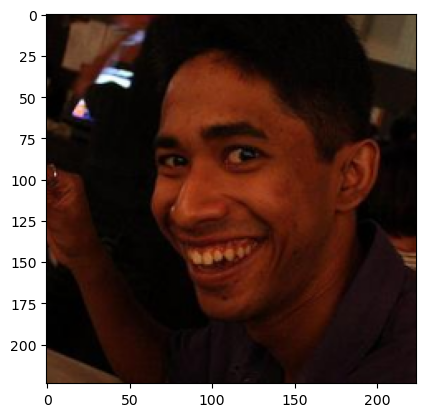


age: tensor(32)
torch.Size([16, 3, 224, 224])


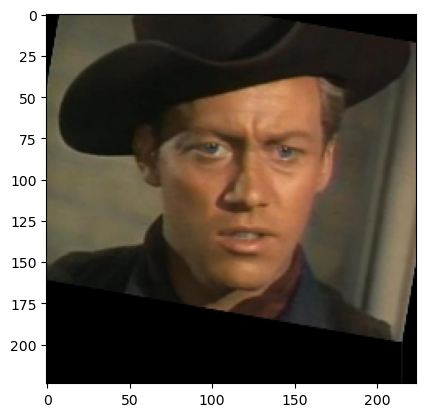


age: tensor(89)
torch.Size([16, 3, 224, 224])


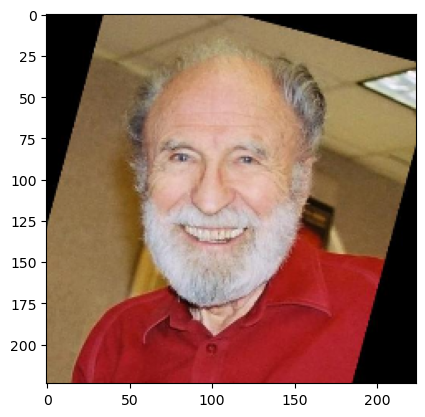

In [16]:
for i in range(16):
    train_features_np = train_features[i].numpy().transpose((1, 2, 0))
    plt.imshow(train_features_np)
    print('age:',train_labels[i])
    print(train_features.shape)
    plt.show()
    print()

### Modelling - ResNet18 finetuning

In [17]:
model_resnet = models.resnet18(pretrained=True)

C:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
input_dim = 500

In [19]:
class ResNetRegressor(nn.Module):
    def __init__(self, model_resnet, input_dim):
        super().__init__()
        self.model_resnet = model_resnet
        num_features = self.model_resnet.fc.in_features #512
        self.model_resnet.fc = nn.Linear(num_features, input_dim)
        self.lin_layer = nn.Linear(input_dim, 1)
        self.relu = nn.ReLU()
                

    def forward(self, inputs):
        output = self.model_resnet(inputs)
        output = self.relu(output)
        output = self.lin_layer(output)
        output = self.relu(output)
                  
        return output  
    

In [20]:
model = ResNetRegressor(model_resnet,input_dim)

In [21]:
# preds = model(train_features)
# mae = torch.sum(torch.abs(torch.squeeze(preds,1)-train_labels))
# mae

In [22]:
learning_rate = 0.0001
num_epochs = 15

In [23]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
model = model.to(device)

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mae = 100000000
    train_loss_list = []
    val_loss_list = []
        
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_mae = 0.0

            # Iterate over data.
            for ind, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.squeeze(outputs,1)
                    loss = criterion(preds.float(), labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_mae += torch.sum(torch.abs(preds-labels))
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mae = running_mae / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step()
                train_loss_list.append(epoch_loss)
                                              

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_mae))

            # deep copy the model
            if phase == 'val' and epoch_mae < best_mae:
                best_mae = epoch_mae
                best_model_wts = copy.deepcopy(model.state_dict())
                val_loss_list.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val mae: {:4f}'.format(best_mae))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_list, val_loss_list
    
    

In [25]:
model_conv, train_loss_list, val_loss_list = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 298.5554 Acc: 12.9428
val Loss: 128.1496 Acc: 8.9586
test Loss: 173.6344 Acc: 10.3484

Epoch 1/14
----------
train Loss: 128.4933 Acc: 8.8064
val Loss: 104.1672 Acc: 7.6567
test Loss: 134.7403 Acc: 8.8284

Epoch 2/14
----------
train Loss: 119.4883 Acc: 8.3742
val Loss: 101.8189 Acc: 7.4970
test Loss: 126.2911 Acc: 8.3579

Epoch 3/14
----------
train Loss: 105.3324 Acc: 7.9538
val Loss: 97.7626 Acc: 7.3300
test Loss: 128.0415 Acc: 8.4450

Epoch 4/14
----------
train Loss: 92.1956 Acc: 7.4231
val Loss: 83.5385 Acc: 6.7239
test Loss: 113.2056 Acc: 7.7916

Epoch 5/14
----------
train Loss: 79.5324 Acc: 6.7930
val Loss: 81.1686 Acc: 6.6678
test Loss: 106.8939 Acc: 7.5624

Epoch 6/14
----------
train Loss: 77.3973 Acc: 6.7198
val Loss: 83.9251 Acc: 6.6480
test Loss: 116.8070 Acc: 7.7688

Epoch 7/14
----------
train Loss: 76.5152 Acc: 6.6724
val Loss: 88.4892 Acc: 6.9771
test Loss: 108.9026 Acc: 7.8389

Epoch 8/14
----------
train Loss: 68.8950 Acc: 6.2605
v

In [27]:
torch.save(model_conv.state_dict(), '../cv/model_resnet_albumentations')

### Тест

Положить в папку test_directory свои фотографии. Запустить score images.

In [28]:
#model_conv = ResNetRegressor(model_resnet,input_dim)
#model_conv.load_state_dict(torch.load('../cv/model_resnet_albumentations'))

In [55]:
def score_images(model, path_dir):
    for filename in os.listdir(path_dir):
        path_file = os.path.join(path_dir, filename)
        print(path_file)
        try:
            image = cv2.imread(path_file)

            crop_size = min(image.shape[0],image.shape[1])
            transform = A.Compose([
                A.CenterCrop(crop_size,crop_size),
                A.Resize(224,224),
                ])

            transformed = transform(image=image)
            image = transformed["image"]
            plt.imshow(image)
            plt.show()
            image = torch.from_numpy(image)
            image = torch.transpose(torch.transpose(image,1,2),0,1)
            image = image/255
            image = torch.unsqueeze(image,dim=0)

            model.eval()
            model.to('cpu')
            score = model(image).item()
            print('Age:',round(score,2))
            print('-'*100)
            print()
        except:
            pass
    

../cv/datasets/faces/other files/my2/154_7.jpg


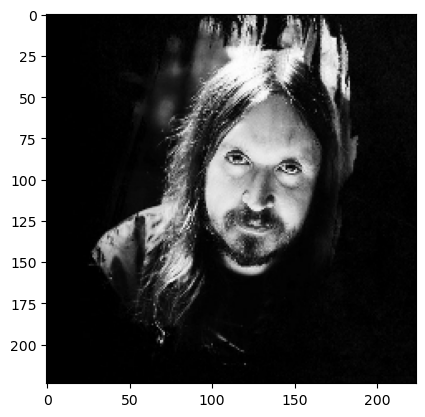

Age: 41.88
----------------------------------------------------------------------------------------------------



In [56]:
test_directory = '../cv/datasets/faces/other files/my2/'
score_images(model_conv,test_directory)

In [48]:
def get_preds2(model,loader):
    
    pred_list = []
    model.to(device)
    model.eval()
          
    for ind, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.squeeze(outputs,1)
        pred_list.extend(preds.cpu().tolist())
    return pred_list         

In [49]:
labels_test['preds'] = get_preds2(model_conv,test_loader)

In [50]:
labels_test.head(40)

,file_name_new,real_age,preds
0,005613.jpg_face.jpg,19,19.733694
1,005614.jpg_face.jpg,76,69.641098
2,005615.jpg_face.jpg,40,32.223106
3,005616.jpg_face.jpg,21,23.391216
4,005617.jpg_face.jpg,34,27.211731
5,005618.jpg_face.jpg,36,38.921799
6,005619.jpg_face.jpg,36,22.735550
7,005620.jpg_face.jpg,52,53.819305
8,005621.jpg_face.jpg,16,17.747383
9,005622.jpg_face.jpg,59,52.095596


In [51]:
from sklearn.metrics import mean_absolute_error
print('MAE on test:', round(mean_absolute_error(labels_test['real_age'],labels_test['preds']),2))

MAE on test: 7.35
